In [ ]:
import pandas as pd 
import mordred
import joblib
import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolops import SanitizeMol
from rdkit.Chem.MolStandardize import rdMolStandardize
from mordred import Calculator
from mordred import descriptors
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv("./data/AqSolDB.csv")
df.head()

,Unnamed: 0,SMILES,LogS
0,0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127
1,1,O=C1Nc2cccc3cccc1c23,-3.254767
2,2,Clc1ccc(C=O)cc1,-2.177078
3,3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409
4,4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065


In [3]:
df.drop(columns="Unnamed: 0", inplace=True)

In [4]:
valid_smiles = []
valid_logs = []

for i, row in df.iterrows():
    smi = row['SMILES']
    logS = row['LogS']
    mol = Chem.MolFromSmiles(smi)
    
    if mol is not None:
        try:
            # Sanitize molecule (check valence, aromaticity, conjugation, hybridization)
            SanitizeMol(mol)
            
            # Canonicalize SMILES to have consistent representation
            clean_smi = Chem.MolToSmiles(mol, canonical=True)
            
            valid_smiles.append(clean_smi)
            valid_logs.append(logS)
        
        except Exception as e:
            # Skip molecules that fail sanitization
            continue

# Create a cleaned DataFrame
clean_df = pd.DataFrame({'SMILES': valid_smiles, 'LogS': valid_logs})

print(f"✅ Valid molecules after sanitization: {len(clean_df)} / {len(df)}")
clean_df.head()

[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not removing hydrogen atom without neighbors
[16:04:28] WARNING: not r

✅ Valid molecules after sanitization: 9982 / 9982


,SMILES,LogS
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,O=C1Nc2cccc3cccc1c23,-3.254767
2,O=Cc1ccc(Cl)cc1,-2.177078
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065


In [5]:
def standardize_molecule(mol):
    try:
        # Remove salts and fragments
        cleaner = rdMolStandardize.Cleanup(mol)
        # Normalize functional groups
        normalizer = rdMolStandardize.Normalize(cleaner)
        # Reionize to standard charge states
        reionizer = rdMolStandardize.Reionize(normalizer)
        return reionizer
    except:
        return mol  # return original if fails

In [6]:
standardized_smiles = []

for smi in df['SMILES']:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mol = standardize_molecule(mol)
        clean_smi = Chem.MolToSmiles(mol, canonical=True)
        standardized_smiles.append(clean_smi)
    else:
        standardized_smiles.append(None)

df['Standardized_SMILES'] = standardized_smiles
df = df.dropna(subset=['Standardized_SMILES']).reset_index(drop=True)

df.to_csv("standardized_AqSolDB.csv", index=False)
print(f"✅ Standardized dataset saved with {len(df)} molecules")
df.head()

[16:04:30] Initializing MetalDisconnector
[16:04:30] Running MetalDisconnector
[16:04:30] Initializing Normalizer
[16:04:30] Running Normalizer
[16:04:30] Initializing Normalizer
[16:04:30] Running Normalizer
[16:04:30] Initializing MetalDisconnector
[16:04:30] Running MetalDisconnector
[16:04:30] Initializing Normalizer
[16:04:30] Running Normalizer
[16:04:30] Initializing Normalizer
[16:04:30] Running Normalizer
[16:04:30] Initializing MetalDisconnector
[16:04:30] Running MetalDisconnector
[16:04:30] Initializing Normalizer
[16:04:30] Running Normalizer
[16:04:30] Initializing Normalizer
[16:04:30] Running Normalizer
[16:04:30] Initializing MetalDisconnector
[16:04:30] Running MetalDisconnector
[16:04:30] Initializing Normalizer
[16:04:30] Running Normalizer
[16:04:30] Initializing Normalizer
[16:04:30] Running Normalizer
[16:04:30] Initializing MetalDisconnector
[16:04:30] Running MetalDisconnector
[16:04:30] Initializing Normalizer
[16:04:30] Running Normalizer
[16:04:30] Initializ

✅ Standardized dataset saved with 9982 molecules


[16:04:41] Initializing MetalDisconnector
[16:04:41] Running MetalDisconnector
[16:04:41] Initializing Normalizer
[16:04:41] Running Normalizer
[16:04:41] Initializing Normalizer
[16:04:41] Running Normalizer
[16:04:41] Initializing MetalDisconnector
[16:04:41] Running MetalDisconnector
[16:04:41] Initializing Normalizer
[16:04:41] Running Normalizer
[16:04:41] Initializing Normalizer
[16:04:41] Running Normalizer
[16:04:41] Initializing MetalDisconnector
[16:04:41] Running MetalDisconnector
[16:04:41] Initializing Normalizer
[16:04:41] Running Normalizer
[16:04:41] Initializing Normalizer
[16:04:41] Running Normalizer
[16:04:41] Initializing MetalDisconnector
[16:04:41] Running MetalDisconnector
[16:04:41] Initializing Normalizer
[16:04:41] Running Normalizer
[16:04:41] Initializing Normalizer
[16:04:41] Running Normalizer
[16:04:41] Initializing MetalDisconnector
[16:04:41] Running MetalDisconnector
[16:04:41] Initializing Normalizer
[16:04:41] Running Normalizer
[16:04:41] Initializ

,SMILES,LogS,Standardized_SMILES
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-]
1,O=C1Nc2cccc3cccc1c23,-3.254767,O=C1Nc2cccc3cccc1c23
2,Clc1ccc(C=O)cc1,-2.177078,O=Cc1ccc(Cl)cc1
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...


In [7]:
df.to_csv("./data/AqSolDB_sanitization_standardization.csv", index=False)

In [8]:
df = df[['SMILES', 'Standardized_SMILES', 'LogS']]

In [9]:
df.head()

,SMILES,Standardized_SMILES,LogS
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,O=C1Nc2cccc3cccc1c23,O=C1Nc2cccc3cccc1c23,-3.254767
2,Clc1ccc(C=O)cc1,O=Cc1ccc(Cl)cc1,-2.177078
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065


In [10]:
calc = mordred.Calculator(descriptors, ignore_3D=True)
mols = [rdkit.Chem.MolFromSmiles(smi) for smi in df["Standardized_SMILES"]]
mols = calc.pandas(mols=mols)

NameError: name 'rdkit' is not defined

In [ ]:
mols = mols.apply(pd.to_numeric, errors='coerce')
df_descriptors = pd.concat([df,mols],axis=1)
df_descriptors.shape

(9982, 1616)

In [ ]:
df_descriptors.dropna(axis=1,how="all",inplace=True)
df_descriptors.shape

(9982, 1554)

In [ ]:
df_descriptors.dropna(axis=0, thresh=len(df_descriptors.columns) * 0.9, inplace=True)
df_descriptors.shape

(6674, 1554)

In [ ]:
df_descriptors.dropna(axis=1,how="all",inplace=True)
df_descriptors.shape

(6674, 1540)

In [ ]:
meta_info = df.loc[df_descriptors.index]
df_descriptors.drop(columns=["SMILES","Standardized_SMILES","LogS"],inplace=True)
df_descriptors.isna().sum().sum()

628247

In [ ]:
imp = SimpleImputer(missing_values=np.nan,strategy="median")
imputed = imp.fit_transform(df_descriptors)
df_descriptors_imputed = pd.DataFrame(imputed,columns=df_descriptors.columns,index=df_descriptors.index)
df_descriptors_imputed_final = pd.concat([meta_info, df_descriptors_imputed], axis=1)
df_descriptors_imputed_final.describe()

,LogS,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
count,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,...,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000
mean,-3.504789,14.269130,12.222184,0.186994,0.160324,23.512773,2.349226,4.671655,23.512773,1.228801,...,9.517824,54.898564,279.993855,8.031002,1235.356458,27.683099,93.526820,107.267456,7.401022,4.317288
std,2.239286,6.682449,4.586412,0.535091,0.543955,10.846370,0.168928,0.318354,10.846370,0.068628,...,0.758400,13.875405,124.252034,2.557120,3745.152192,17.081020,47.049721,58.411242,3.203053,1.843100
min,-13.171900,4.242641,4.530950,0.000000,0.000000,8.054679,1.847759,3.695518,8.054679,0.913059,...,6.900731,30.257210,92.062600,4.353270,56.000000,4.000000,22.000000,20.000000,2.472222,2.000000
25%,-4.799963,10.037394,9.264883,0.000000,0.000000,16.561057,2.258859,4.510506,16.561057,1.186830,...,9.094144,44.996189,198.104465,6.442966,304.000000,17.000000,64.000000,69.000000,5.444444,3.166667
50%,-3.170550,12.991790,11.421647,0.000000,0.000000,21.282883,2.368106,4.714014,21.282883,1.233769,...,9.601098,51.379535,255.961333,7.568088,559.000000,24.000000,84.000000,96.000000,6.805556,3.916667
75%,-1.919351,16.913961,14.145288,0.000000,0.000000,27.650999,2.459290,4.872484,27.650999,1.273861,...,10.018712,62.947493,330.235342,8.824366,1086.750000,34.000000,112.000000,131.000000,8.527778,4.916667
max,2.137682,127.990526,93.771600,12.000000,10.000000,197.393182,2.922960,5.616562,197.393182,1.440493,...,12.283270,208.825246,2284.054626,41.268621,196386.000000,311.000000,894.000000,1066.000000,68.722222,34.750000


In [ ]:
df_descriptors_imputed_final.to_csv("./data/AqSolDB_descriptors_imputed.csv")

In [ ]:
df_descriptors = pd.read_csv("./data/AqSolDB_descriptors_imputed.csv")

In [ ]:
# Extract features (X) and target (y)

X = df_descriptors.iloc[:, 5:]  # columns after first 5 are Mordred descriptors
y = df_descriptors['LogS']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (6674, 1536)
Target shape: (6674,)


In [ ]:
# Keep only numerics
X = X.select_dtypes(include=[np.number])  
X = X.replace([np.inf, -np.inf], np.nan)

# Keep columns with at least 80% nonNaN values
X = X.dropna(axis=1, thresh=0.8 * len(X))  
X = X.fillna(X.mean())

print(f"Features after cleaning: {X.shape}")

Features after cleaning: (6674, 1536)


In [ ]:
# Split train-test da
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

print(f"Training set: {X_train.shape[0]} molecules")
print(f"Test set: {X_test.shape[0]} molecules")

Training set: 5339 molecules
Test set: 1335 molecules


In [ ]:
# Scale the data
print("Scaling data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Scaling data...


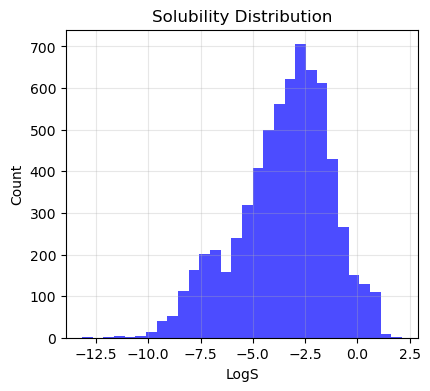

In [ ]:
# Solubility distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(y, bins=30, alpha=0.7, color='blue')
plt.xlabel('LogS')
plt.ylabel('Count')
plt.title('Solubility Distribution')
plt.grid(True, alpha=0.3)

In [ ]:
# Train SVM model
print("Training SVM model...")

svm_model = SVR(kernel = 'rbf', C = 1.0, epsilon = 0.1 , gamma = 'scale') # Got good results with defaults

svm_model.fit(X_train_scaled, y_train)

print("SVM training completed!")

Training SVM model...
SVM training completed!


In [ ]:
# Evaluate w/ epsilon 0.1 and C = 1.0
y_pred_test = svm_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(
    "SVM's Performance on Test Set:\n"
    f"  Mean Absolute Error:      {mae:.3f}\n"
    f"  R²:                       {r2:.3f}\n"
    f"  Root Mean Squared Error:  {rmse:.3f}"
)

SVM's Performance on Test Set:
  Mean Absolute Error:      0.648
  R²:                       0.813
  Root Mean Squared Error:  0.943


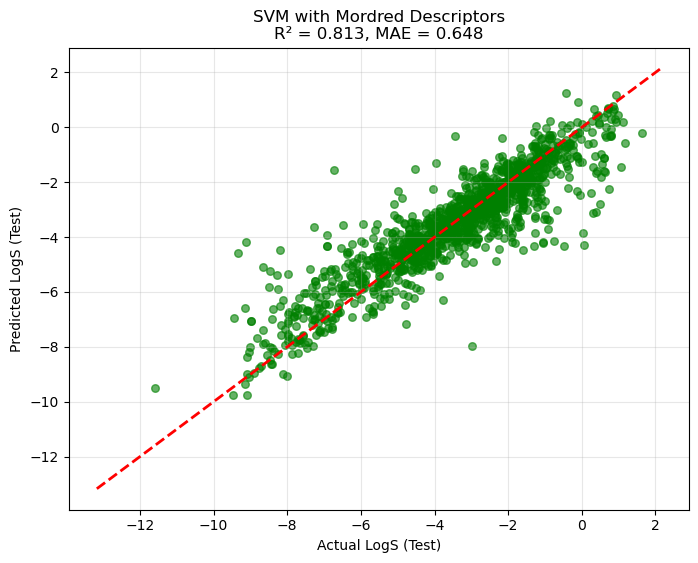

In [ ]:
# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, s=30, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual LogS (Test)')
plt.ylabel('Predicted LogS (Test)')
plt.title(f'SVM with Mordred Descriptors\nR² = {r2:.3f}, MAE = {mae:.3f}')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
model_data = {
    'model': svm_model,
    'scaler': scaler,
    'feature_names': X.columns.tolist()
}
joblib.dump(model_data, 'svm_solubility_model.pkl')
print("Model saved as 'svm_solubility_model.pkl'")

Model saved as 'svm_solubility_model.pkl'
